# Multidim Sampling
<hr style="border-top-width: 4px; border-top-color: #34609b;">
Example of sampling a multi-dim distribution using the DistSampler class
NOTE: This tutorial must be run with ACLIC




**Author:** Lorenzo Moneta  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-mirror/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer (Beta)</a> from the macro found in the ROOT repository  on Thursday, January 19, 2017 at 04:33 PM.</small></i>

Function (a 4d gaussian)

In [1]:
%%cpp -d
#include "TMath.h"
#include "TF2.h"
#include "TStopwatch.h"
#include "Math/DistSampler.h"
#include "Math/DistSamplerOptions.h"
#include "Math/MinimizerOptions.h"
#include "Math/Factory.h"

#include "TKDTreeBinning.h"

#include "TTree.h"
#include "TFile.h"
#include "TMatrixDSym.h"
#include "TVectorD.h"
#include "TCanvas.h"
#include <cmath>

Gauss nd function
 make a class in order to avoid constructing the
 matrices for every call
 This however requires that  the code must be compiled with ACLIC

In [2]:
bool debug = false;

Define the gausnd strcture

In [3]:
struct GausND {

   TVectorD X;
   TVectorD Mu;
   TMatrixDSym CovMat;

   GausND( int dim ) :
      X(TVectorD(dim)),
      Mu(TVectorD(dim)),
      CovMat(TMatrixDSym(dim) )
   {}

   double operator() (double *x, double *p) {
      // 4 parameters
      int dim = X.GetNrows();
      int k = 0;
      for (int i = 0; i<dim; ++i) { X[i] = x[i] - p[k]; k++; }
      for (int i = 0; i<dim; ++i) {
         CovMat(i,i) = p[k]*p[k];
         k++;
      }
      for (int i = 0; i<dim; ++i) {
         for (int j = i+1; j<dim; ++j) {
            // p now are the correlations N(N-1)/2
               CovMat(i,j) = p[k]*sqrt(CovMat(i,i)*CovMat(j,j));
               CovMat(j,i) = CovMat(i,j);
               k++;
         }
      }
      if (debug) {
         X.Print();
         CovMat.Print();
      }

      double det = CovMat.Determinant();
      if (det <= 0) {
         Fatal("GausND","Determinant is <= 0 det = %f",det);
         CovMat.Print();
         return 0;
      }
      double norm = std::pow( 2. * TMath::Pi(), dim/2) * sqrt(det);
      // compute the gaussians
      CovMat.Invert();
      double fval  = std::exp( - 0.5 * CovMat.Similarity(X) )/ norm;

      if (debug) {
         std::cout << "det  " << det << std::endl;
         std::cout << "norm " << norm << std::endl;
         std::cout << "fval " << fval << std::endl;
      }

      return fval;
   }
};

Use the math namespace

In [4]:
%%cpp -d
// This is a workaround to make sure the namespace is used inside functions
using namespace ROOT::Math;

In [5]:
const int N = 10000;
/*const int NBin = 1000;*/
const int DIM = 4;

double xmin[] = {-10,-10,-10, -10};
double xmax[] = { 10, 10, 10,  10};
double par0[] = { 1., -1., 2, 0, // the gaussian mu
                  1, 2, 1, 3, // the sigma
                  0.5,0.,0.,0.,0.,0.8 };  // the correlation

const int NPAR = DIM + DIM*(DIM+1)/2; // 14 in the 4d case

Generate the sample

In [6]:
GausND gaus4d(4);
TF1 * f = new TF1("functionND",gaus4d,0,1,14);
f->SetParameters(par0);

double x0[] = {0,0,0,0};

For debugging

In [7]:
if (debug) f->EvalPar(x0,0);
debug = false;

TString name;
for (int i = 0; i < NPAR; ++i )  {
   if (i < DIM) f->SetParName(i, name.Format("mu_%d",i+1) );
   else if (i < 2*DIM) f->SetParName(i, name.Format("sig_%d",i-DIM+1) );
   else if (i < 2*DIM) f->SetParName(i, name.Format("sig_%d",i-2*DIM+1) );
}

/*ROOT::Math::DistSamplerOptions::SetDefaultSampler("Foam");*/
DistSampler * sampler = Factory::CreateDistSampler();
if (sampler == 0) {
   Info("multidimSampling","Default sampler %s is not available try with Foam ",
        ROOT::Math::DistSamplerOptions::DefaultSampler().c_str() );
   ROOT::Math::DistSamplerOptions::SetDefaultSampler("Foam");
}
sampler = Factory::CreateDistSampler();
if (sampler == 0) {
   Error("multidimSampling","Foam sampler is not available - exit ");
   return;
}

sampler->SetFunction(*f,DIM);
sampler->SetRange(xmin,xmax);
bool ret = sampler->Init();

std::vector<double> data1(DIM*N);
double v[DIM];
TStopwatch w;

if (!ret) {
   Error("Sampler::Init","Error initializing unuran sampler");
   return;
}

Generate the data

In [8]:
w.Start();
for (int i = 0; i < N; ++i) {
   sampler->Sample(v);
   for (int j = 0; j < DIM; ++j)
      data1[N*j + i]     = v[j];
}
w.Stop();
// w.Print();

Fill tree with data

In [9]:
TFile * file = new TFile("multiDimSampling.root","RECREATE");
double x[DIM];
TTree * t1 = new TTree("t1","Tree from Unuran");
t1->Branch("x",x,"x[4]/D");
for (int i = 0; i < N; ++i) {
   for (int j = 0; j < DIM; ++j) {
      x[j] = data1[i+N*j];
   }
   t1->Fill();
}

Plot the data

In [10]:
t1->Draw("x[0]:x[1]:x[2]:x[3]","","candle");
TCanvas * c2 = new TCanvas();
c2->Divide(3,2);
int ic=1;
c2->cd(ic++);
t1->Draw("x[0]:x[1]");
c2->cd(ic++);
t1->Draw("x[0]:x[2]");
c2->cd(ic++);
t1->Draw("x[0]:x[3]");
c2->cd(ic++);
t1->Draw("x[1]:x[2]");
c2->cd(ic++);
t1->Draw("x[1]:x[3]");
c2->cd(ic++);
t1->Draw("x[2]:x[3]");

t1->Write();
file->Close();

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


Draw all canvases 

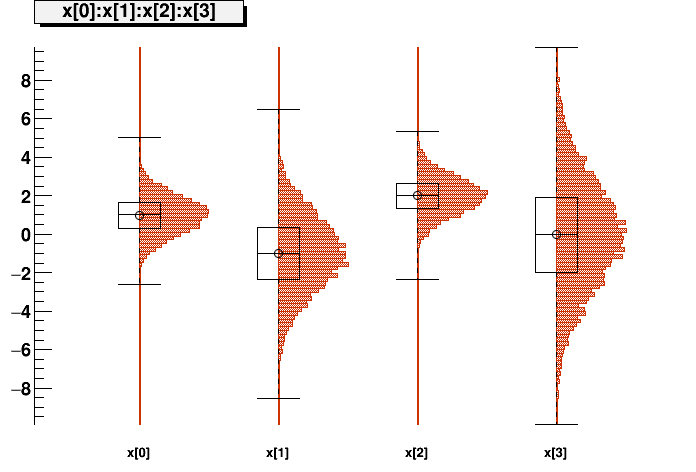

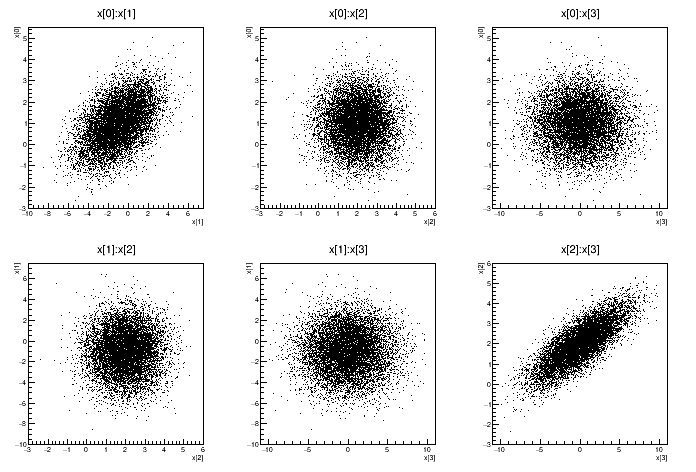

In [11]:
gROOT->GetListOfCanvases()->Draw()